# Implementação do Algoritmo Simplex

In [3]:
# Bibliotecas
import math
import numpy as np
import time

In [4]:
# Funcao para imprimir tableu
def print_tableau(tableau):
    lins = len(tableau)
    cols = len(tableau[0])

    header =  ['x' + str(i+1) for i in range(cols-1)]
    print('           ' + ''.join(f'{col:>8}' for col in header))
    print('              ' + '-' * (7 * cols))

    print('F.O. ' + ''.join(f'{val:8.2f}' for val in tableau[0]))
    for i in range(1,lins-1):
        print(f'x{tableau[-1][i-1]+1} = ' + ''.join(f'{val:8.2f}' for val in tableau[i]))

    print()

def round_list(lista):
    return [round(x, 4) for x in lista]

def print_solution(lista):
    if lista != None:
        print("Solução ótima: (", ', '.join(str(x) for x in round_list(lista)), ")")


# Fase 1: obter solução básica viável

In [5]:
# Procura alguma coluna da matriz Identidade
def eh_basica(coluna):
    return sum(coluna) == 1 and len([c for c in coluna if c == 0]) == len(coluna) - 1

# Retorna o indice onde esta "1"
def get_one(vector):
    for i in range(len(vector)):
        if vector[i] == 1:
            return i

# Valores muito proximos de zero
def is_zero(element):
    return abs(element) <= 10e-4

# Funcao que guarda o indice das variaveis basicas
# associado a coluna da matriz identidade
def basicas(A):
    id = [0] * len(A)       # coluna da identidade
    i_B = [-1] * len(A)     # indice da variavel
    colunas = np.array(A).T
    for coluna in range(0, len(colunas)):
        if eh_basica(colunas[coluna]) and id[get_one(colunas[coluna])] == 0:
            i_B[get_one(colunas[coluna])]= coluna
            id[get_one(colunas[coluna])] = 1
    return id, i_B
# OBS: quando escreve basicas(A)[0] --> acessa quais colunas
#                     basicas(A)[1] --> acessa os indices (-1) das basicas

def fase1(c, A, b):
    nvar = len(A[0])
    d = (False, nvar)
    # Verifica se é necessario adicionar variaveis artificiais
    tem_sol_basica = any(x == -1 for x in basicas(A)[1])
    if not tem_sol_basica:
        d = (False, nvar)
        return c, A, b, d

    # Custos da nova funcao
    c1 = [0] * len(c)    # zero para as variaveis originais
    id = basicas(A)[0]
    for i in range(0, len(id)):
        if id[i] == 0:
            coluna = [0] * len(id)
            coluna[i] = 1
            for linha in range(0, len(A)):
                A[linha].append(coluna[linha])
            c1.append(1)  # um para as variaveis artificiais

    # se precisou adicionar variaveis
    d = (True, nvar)

    return c1, A, b, d

A fase 1 deve retornar um Tableau !!

Usamos somente as colunas:

    - da funcao objetivo e valores das basicas
    - das variaveis originais
    
OBS: se a solucao encontrada for degenerada entao excluimos a linha de zeros

In [6]:
# Reorganiza o tableau
def resultado_fase1(tableau, nvar):
    # mantem as colunas das variaveis originais
    if not is_zero(tableau[0][0]):
        return None, None

    qtdd_colunas = nvar + 1

    # Verify tableau has valid dimensions before accessing
    if len(tableau) < 2:
        return None, None

    # Obtem os indices das variaveis basicas
    basic_vars = tableau[-1] if len(tableau[-1]) > 0 else []

    novo_A = []
    novo_b = []

    # Processa cada linha, exceto a primeira e a última
    for basica in range(1, len(tableau)-1):
        if basica < len(tableau) and basica < len(basic_vars) and basic_vars[basica] > nvar-1:
            for j in range(1, nvar+1):
                if j < len(tableau[basica]) and not is_zero(tableau[basica][j]):
                    tableau = atualiza_tableau(tableau, (basica, j))

    # mantem as linhas das variaveis basicas originais
    if len(basic_vars) > 0:
        for i, xB in enumerate(basic_vars):
            if i+1 < len(tableau) and xB < qtdd_colunas:
                row = tableau[i+1]
                if len(row) >= qtdd_colunas:
                    novo_A.append(row[1:qtdd_colunas])
                    novo_b.append(row[0])

    return novo_A, novo_b

# Fase 2: Aplicar Método Simplex

## Tableau Inicial

Estamos assumindo que para montar o Tableau está sendo passada uma matriz A que contenha todas as colunas da identidade necessarias para obter uma solucao basica viável.

OBS: garantimos isso pois antes todos os problemas passam pela fase 1


In [7]:
# Monta o Tableau Inicial se passou pela Fase 1
def tableau_inicial_simples(c, A, b):
    linhas_tableau = []

    # guarda as basicas
    identidade, indice_basicas = basicas(A)

    # funcao objetivo e custos reduzidos
    funcao_obj = (-1) * sum(b)
    custos = []
    for j in range(len(A[0])):
        if j not in indice_basicas:
            c_j = 0
            for i in range(len(A)):
                c_j += A[i][j]
            custos.append((-1)*c_j)
        else:
            custos.append(0)

    linhas_tableau.append([funcao_obj]+custos)  # linha 0

    # Concatena linhas de A com linhas de b
    for i in range(len(b)):
        linha = [b[i]] + A[i]
        linhas_tableau.append(linha)

    # indice das variaveis basicas
    linhas_tableau.append(indice_basicas)  # ultima linha
    return linhas_tableau

In [8]:
# Monta o Tableau Inicial se nao passou pela Fase 1
def tableau_inicial(c, A, b):
    linhas_tableau = []

    # guarda as basicas
    identidade, indice_basicas = basicas(A)
    lz = []

     # funcao objetivo e custos reduzidos
    fo = 0
    for i in range(0, len(b)):
        fo += -(b[i] * c[indice_basicas[i]])
    lz.append(fo)

    # Percorre todas as colunas da matriz
    for i in range(0, len(A[0])):
        # se a variavel nao é basica, calcula o custo reduzido
        if i not in indice_basicas:
            col = [A[j][i] for j in range(0, len(A))]
            cust = [c[i] for i in indice_basicas]
            el = sum([a*b for a,b in zip(col,cust)])
            el = c[i] - el
            lz.append(el)
        # se é basica, entao custo é zero
        else:
            lz.append(0)

    linhas_tableau.append(lz)  # linha 0

    # Concatena linhas de A com linhas de b
    for i in range(len(b)):
        linha = [b[i]] + A[i]
        linhas_tableau.append(linha)

    # indice das variaveis basicas
    linhas_tableau.append(indice_basicas)  # ultima linha
    return linhas_tableau

Funções que verificam se a solução é ótima ou não e atualizam o Tableau, se necessário

In [9]:
# Verifica se tem algum custo reduzido negativo
def nao_otima(tableau):
    return any(c < 0 for c in tableau[0][1:])

# Define elemento pivo
def posicao_pivo(tableau):
    custos = tableau[0]
    # Escolhe o primeiro custo reduzido negativo
    # "xj entra na base"
    for j in range(1,len(custos)):
        if custos[j] < 0:
            coluna_pivo = j
            break

    theta = []
    for linha_i in range (1,len(tableau)-1):
        if tableau[linha_i][coluna_pivo] <= 0:
            theta.append(math.inf)
        else:
            theta.append(tableau[linha_i][0] / tableau[linha_i][coluna_pivo])

    # Escolhe o menor indice das variaveis que podem sair da base
    # soma um porque estamos ignorando a linha de custos
    #print("Theta: ",theta)

    if set(theta) == {math.inf}:
        print("Problema ilimitado")
        return None, None

    linha_pivo = theta.index(min(theta)) + 1

    return linha_pivo, coluna_pivo

# Atualiza o tableau com base no pivo encontrado
def atualiza_tableau(tableau, pivo):
    i, j = pivo
    valor_pivo = tableau[i][j]

    # Divide a linha do pivo para que o valor do pivo seja 1
    tableau[i] = np.array(tableau[i]) / valor_pivo

    # Atualiza os valores de dentro do tableau
    # ou seja, zera os outros elementos da coluna
    for linha in range (len(tableau)-1):
        if linha != i:
            multiplicador = (-1) * tableau[linha][j]
            tableau[linha] = multiplicador*tableau[i] + tableau[linha]

            tableau[linha] = np.array([0 if is_zero(x) else x for x in list(tableau[linha])])

    # Atualiza variaveis básicas
    tableau[-1][i-1] = j-1

    return tableau

def otima(tableau, nvar):
    # inicia com todos valendo zero
    solucoes = [0] * nvar

    # coloca o valor das basicas na posicao correta da solucao
    for i, xB in enumerate(tableau[-1]):
        solucoes[xB] = tableau[i+1][0]

    return solucoes



In [10]:


def simplex(c, A, b, d, t_fase1 = False):
    if t_fase1:
        tableau = tableau_inicial(c, A, b)
    else:
        tableau = tableau_inicial_simples(c, A, b)

    #print("Tableau inicial: ")
    #print_tableau(tableau)

    nvar = d[1]

    it = 0
    while nao_otima(tableau) and it < 10000:
        #print_tableau(tableau)
        it = it +1
        pivo = posicao_pivo(tableau)
        if pivo == (None, None):
            return None, None
        tableau = atualiza_tableau(tableau, pivo)
    if d[0]:
        print("Iterações Fase 1: ",it)
    else:
        print("Iterações Fase 2: ",it)
        #print("Tableau atualizado: ")
        #print_tableau(tableau)

    if it == 10000:
        print("Max Iteracoes atingida")
        return None, None



    if d[0]:
        novo_A, novo_b = resultado_fase1(tableau, nvar)
        return novo_A, novo_b
    else:
        #print("Tableau final")
        #print_tableau(tableau)
        return A, otima(tableau, nvar)


## Retorna a solução ótima

In [11]:
def get_solution_simplex(c, A, b):
    inicio = time.time()
    nvar = len(A[0])
    d = (False, nvar)
    c1, A1, b1, d = fase1(c, A, b)

    # Caso seja necessario usar variaveis artificiais (Fase 1)
    if d[0]:
        #print("Simplex FASE 1: ")
        A2, b2 = simplex(c1,A1,b1,d)
        if A2 is None:
            print("Problema infactivel")
            return None
        #else:
            #print("Resultado da fase 1: ",b2)

        # Convertendo tudo para mesmo formato que o simplex (Fase 2)
        A2 = [[float(x) for x in row] for row in A2]
        b2 = [float(x) for x in b2]

        fA, fb = simplex(c, A2, b2,(False, nvar), True)
        print_solution(fb)
        return True

    # Não foi necessario usar a fase 1 (Resolve direto Fase 2)
    else:
        fA, fb = simplex(c, A1, b1, d)
        print_solution(fb)
        return True

    fim = time.time()
    print("Tempo de execução: ", fim - inicio)

# Testando alguns exemplos #

### Slides aula 23

Solucão básica viável para iniciar o simplex:
(x1,x2,x3,x4) = (1 ; 1/2 ; 1/3 ; 0) e zero nas variaveis artificiais

Problema: A tem linhas LD --> sol. encontrada na fase 1 é degenerada

In [12]:
# Coeficientes da função objetivo
c = [1, 1, 1, 0]

# Matriz de coeficientes das restrições
A = [
    [1, 2, 3, 0],
    [-1, 2, 6, 0],
    [0, 4, 9, 0],
    [0, 0, 3, 1]
]

# Vetor de termos independentes das restrições
b = [3, 2, 5, 1]

get_solution_simplex(c, A, b)

Iterações Fase 1:  3
Iterações Fase 2:  1
Solução ótima: ( 0.5, 1.25, 0, 1.0 )


True

### Sei la
Solução ótima: (3,2,0,0)

In [13]:
# Coeficientes da função objetivo
c = [-2, -1, 0, 0]

# Matriz de coeficientes das restrições
A = [
    [-1, 1, 1, 0],
    [1, 2, 0, 1]
]

# Vetor de termos independentes das restrições
b = [-1, 7]

get_solution_simplex(c, A, b)

Iterações Fase 2:  2
Solução ótima: ( 3.0, 2.0, 0, 0 )


True

### Lista 20
Solução ótima: (1,5,0)

In [14]:
# Coeficientes da função objetivo
c = [4, 3, 7]

# Matriz de coeficientes das restrições
A = [
    [2, 2, 1],
    [3, 1, 2]
]

# Vetor de termos independentes das restrições
b = [12, 8]

get_solution_simplex(c, A, b)

Iterações Fase 1:  2
Iterações Fase 2:  0
Solução ótima: ( 1.0, 5.0, 0 )


True

### Lista 20
Trocando b para (5,8)

Solução ótima: (2,0,1)

In [15]:
# Coeficientes da função objetivo
c = [4, 3, 7]

# Matriz de coeficientes das restrições
A = [
    [2, 2, 1],
    [3, 1, 2]
]

# Vetor de termos independentes das restrições
b = [5, 8]

get_solution_simplex(c, A, b)

Iterações Fase 1:  2
Iterações Fase 2:  0
Solução ótima: ( 2.0, 0, 1.0 )


True

### Lista 16
Solução: problema infactível

In [16]:
# Coeficientes da função objetivo
c = [2, -1, 5, 0]

# Matriz de coeficientes das restrições
A = [
    [1, 1, 1, 0],
    [2, 3, 2, 1]
]

# Vetor de termos independentes das restrições
b = [4, 5]

get_solution_simplex(c, A, b)

Iterações Fase 1:  1
Problema infactivel


### Lista 13
Solução: (-1/3,10/3)

In [17]:
# Coeficientes da função objetivo
#x1+, x1-, x2, x3, x4, x5
c = [-1, 1, 1, 0, 0, 0]

# Matriz de coeficientes das restrições
A = [
    [1, -1, 1, -1, 0, 0],
    [-1, 1, 1, 0, 1, 0],
    [-2, 2, 1, 0, 0, -1]
]

# Vetor de termos independentes das restrições
b = [3, 4, 4]

get_solution_simplex(c, A, b)

Iterações Fase 1:  3
Iterações Fase 2:  1
Solução ótima: ( 0, 0.3333, 3.3333, 0, 0.3333, 0 )


True

### Algum problema ilimitado


In [18]:
# Coeficientes da função objetivo
c = [3, -3, 4, -4, 0]

# Matriz de coeficientes das restrições
A = [
    [1, -1, 2, -2, 1],
    [2, -2, 1, -1, -1]
]

# Vetor de termos independentes das restrições
b = [8, 6]

get_solution_simplex(c, A, b)

Iterações Fase 1:  2
Problema ilimitado


True

Coeficientes da função objetivo:
[10]

Matriz de coeficientes das restrições:
[5]

Vetor de termos independentes das restrições:
[8]
Iterações Fase 1:  1
Iterações Fase 2:  0
Solução ótima: ( 1.6 )
Coeficientes da função objetivo:
[10, 2]

Matriz de coeficientes das restrições:
[5, 4]
[9, 4]

Vetor de termos independentes das restrições:
[13, 15]
Iterações Fase 1:  2
Iterações Fase 2:  0
Solução ótima: ( 0.5, 2.625 )
Coeficientes da função objetivo:
[6, 10, 8]

Matriz de coeficientes das restrições:
[5, 4, 10]
[3, 4, 6]
[9, 10, 3]

Vetor de termos independentes das restrições:
[24, 16, 23]
Iterações Fase 1:  3
Iterações Fase 2:  0
Solução ótima: ( 0.9333, 1.0, 1.5333 )
Coeficientes da função objetivo:
[4, 7, 1, 2]

Matriz de coeficientes das restrições:
[5, 6, 6, 10]
[8, 1, 10, 8]
[4, 6, 3, 10]
[4, 5, 4, 1]

Vetor de termos independentes das restrições:
[29, 31, 25, 19]
Iterações Fase 1:  5
Iterações Fase 2:  0
Solução ótima: ( 2.5185, 1.2742, 0.4938, 0.58 )
Coeficientes da função obje

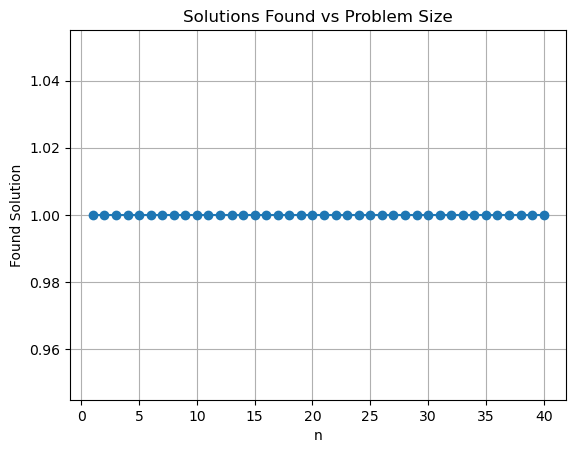

In [19]:
import random
nmax = 40
def gerar_problema_programacao_linear(n):
    # Gerar o vetor c (coeficientes da função objetivo)
    c = [random.randint(1, 10) for _ in range(n)]

    # Gerar a matriz A (coeficientes das restrições)
    A = []
    for i in range(n):
        linha = [random.randint(1, 10) for _ in range(n)]
        A.append(linha)

    # Gerar o vetor b (termos independentes das restrições)
    b = [random.randint(10, 20) for _ in range(n)]

    # Garantir que o problema seja factível ajustando os valores
    for i in range(n):
        A[i][i] = random.randint(1, 5)  # Garantir que a diagonal tenha coeficientes positivos
        b[i] = random.randint(1, 5) + sum(A[i])  # Ajustar b para garantir factibilidade

    # Exibir o problema gerado
    print("Coeficientes da função objetivo:")
    print(c)
    print("\nMatriz de coeficientes das restrições:")
    for linha in A:
        print(linha)
    print("\nVetor de termos independentes das restrições:")
    print(b)
    res = get_solution_simplex(c, A, b)
    if res:
        return 1
    else:
        return 0

# Exemplo de uso com n = 3
n = 10

find = []
for i in range(1, nmax+1):  # Limit range to valid sizes 1-10
    found = 0
    for j in range(20):
        found = gerar_problema_programacao_linear(i)
        if found == 1:
            find.append(found)
            break
    if found == 0:
        find.append(0)

import matplotlib.pyplot as plt

n_values = list(range(1, nmax+1))
plt.plot(n_values, find, marker='o')
plt.xlabel('n')
plt.ylabel('Found Solution')
plt.title('Solutions Found vs Problem Size')
plt.grid(True)
plt.show()


Coeficientes da função objetivo:Coeficientes da função objetivo:Coeficientes da função objetivo:


[5]Coeficientes da função objetivo:
[4, 9, 2, 5, 5, 8, 2, 7, 4][9, 5, 5, 1, 4]


[2, 8, 3, 1, 7, 1, 7, 9, 2, 1, 3, 7, 4]
Matriz de coeficientes das restrições:
Matriz de coeficientes das restrições:

[1, 7, 5, 10, 2, 4, 10, 1, 7]

Matriz de coeficientes das restrições:
Matriz de coeficientes das restrições:
[5]

[2, 8, 7, 6, 8][3, 2, 8, 7, 3, 3, 7, 2, 9, 5, 5, 5, 9]

[8, 1, 7, 2, 5, 4, 9, 2, 9]

Vetor de termos independentes das restrições:

[9, 1, 10, 1, 5][10, 3, 3, 9, 8, 1, 3, 10, 10][10][7, 1, 6, 4, 8, 7, 4, 6, 8, 1, 10, 10, 8]



[10, 7, 5, 1, 6, 10, 6, 1, 10, 7, 8, 10, 4][1, 1, 9, 3, 3, 10, 3, 4, 10][9, 1, 2, 3, 9]
[5, 2, 3, 10, 4, 1, 5, 1, 7]


[9, 3, 4, 1, 8][2, 9, 2, 3, 1, 1, 5, 4, 9]Iterações Fase 1: 
[9, 8, 7, 8, 4]
[8, 2, 6, 7, 3, 6, 4, 3, 2] 
1
Vetor de termos independentes das restrições:[9, 5, 9, 1, 10, 10, 2, 10, 5, 10, 9, 3, 2]


[35, 30, 26, 29, 40]Iterações Fase 2: [7, 

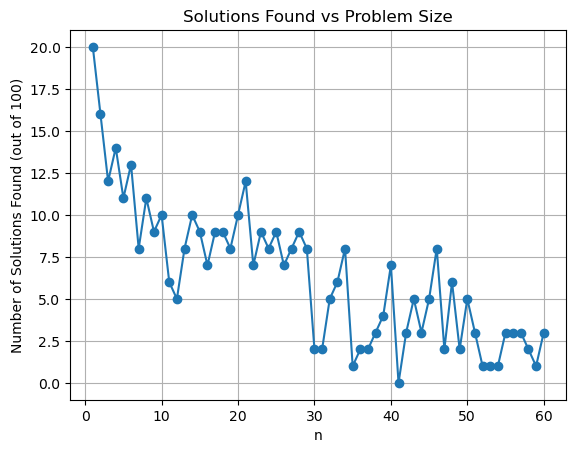

In [20]:

import random
import multiprocessing as mp
from functools import partial

nmax = 100

def gerar_problema_programacao_linear(n):
    # Gerar o vetor c (coeficientes da função objetivo)
    c = [random.randint(1, 10) for _ in range(n)]

    # Gerar a matriz A (coeficientes das restrições)
    A = []
    for i in range(n):
        linha = [random.randint(1, 10) for _ in range(n)]
        A.append(linha)

    # Gerar o vetor b (termos independentes das restrições)
    b = [random.randint(10, 20) for _ in range(n)]

    # Garantir que o problema seja factível ajustando os valores
    for i in range(n):
        A[i][i] = random.randint(1, 5)  # Garantir que a diagonal tenha coeficientes positivos
        b[i] = random.randint(1, 5) + sum(A[i])  # Ajustar b para garantir factibilidade

    # Exibir o problema gerado
    print("Coeficientes da função objetivo:")
    print(c)
    print("\nMatriz de coeficientes das restrições:")
    for linha in A:
        print(linha)
    print("\nVetor de termos independentes das restrições:")
    print(b)
    res = get_solution_simplex(c, A, b)
    if res:
        return 1
    else:
        return 0

def try_find_solution(n):
    solutions = 0
    for j in range(20):
        found = gerar_problema_programacao_linear(n)
        solutions += found
    return solutions

# Exemplo de uso com n = 3
n = 10

# Create a pool of workers
#pool = mp.Pool(processes=mp.cpu_count())
pool = mp.Pool(processes=12)

# Map the work across processes
n_values = list(range(1, nmax+1))
solutions_count = pool.map(try_find_solution, n_values)

# Close the pool
pool.close()
pool.join()

import matplotlib.pyplot as plt

plt.plot(n_values, solutions_count, marker='o')
plt.xlabel('n')
plt.ylabel('Number of Solutions Found (out of 100)')
plt.title('Solutions Found vs Problem Size')
plt.grid(True)
plt.show()


# ---------------------------------------------